dependencies

In [2]:
# !python -m spacy download nb_core_news_sm
# !python -m spacy download nb_core_news_md
# !python -m spacy download nb_core_news_lg
# !pip install sklearn
# !pip install spacy
# !pip install json
# !pip install seaborn

In [3]:
import spacy
import json
import pandas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [4]:
data_3class = {}
for name in ["train", "dev", "test"]:
    with open(f"norec_sentence/3class/{name}.json") as infile:
        data_3class[name] = json.load(infile)

Oure data is orginized so that train, test and dev all include text, lables and sent_id so we re orginize the data. With two dictionaries including train-dev-test we can utilize oure text and lable data with shorter lines of code 

In [5]:
text = {'train': [x['text'] for x in data_3class['train']], 
        'dev' : [x['text'] for x in data_3class['dev']],
        'test':[x['text'] for x in data_3class['test']]}

labels ={'train':[x['label'] for x in data_3class['train']],
         'dev' : [x['label'] for x in data_3class['dev']],
         'test':[x['label'] for x in data_3class['test']]}

custom lemmatizer that lowers every sentence and the uses a spacy model to turn each word into it's lemma if the word is not in the stopword list

In [33]:
def lemmatizer(list_sentc:list, nlp:spacy, stop_words:list)->list:
    """takes a list of sentences and returns a list of lemmatized sentences using the lemma_ 
    atribute from spacy, and list comprehention to filter out stopwords

    Args:
        list_sentc (list): a list of multiword sentences
        nlp (spacy): a spacy language model for lemmatization
        stop_words: a list of stopwords to use for stopwordremoval
        
    Returns:
        list: lemmatized sentences
    """
    result = []
    for sentence in list_sentc:
        if nlp != None:
            doc = nlp(sentence.lower())
            result.append(' '.join([token.lemma_ for token in doc if token.lemma_ not in stop_words]))
        else:
            result.append(' '.join([x for x in sentence.split() if x not in stop_words]))

    return result

the spacy language models that are compatible with oure lemmatizer function

In [28]:
nb_nlp = {'none': None, 'smal': spacy.load('nb_core_news_sm'), 'medium': spacy.load('nb_core_news_md'), 'large':spacy.load('nb_core_news_lg')}

we downloaded two lists of stopwords, source at the end of the notebook, and here we read them and compare their length, we also introduce an empty list as the null option

In [58]:
file_1 = open('stopwords-no.json')
no_stop_1 = json.load(file_1)
print(len(no_stop_1))

file_2 = open('stopwords_nb.txt')
no_stop_2 = file_2.read()
no_stop_2 = no_stop_2.split('\n')
print(len(no_stop_2))

no_stop = {'none':[], 'short': no_stop_2, 'medium': no_stop_1}

221
118


In [61]:
text_comb = text['train'] + text['test'] + text['dev']
vector_1 = TfidfVectorizer().fit(text_comb)
vector_2 = TfidfVectorizer().fit(lemmatizer(text_comb, nb_nlp['large'], no_stop['medium']))

n_features = len(vector_1.get_feature_names_out())

grid = {}

for stop in no_stop:
    for nlp in nb_nlp:
        if nlp == 'none' and stop == 'none':
            grid['none-none'] = vector_1
            continue
        
        vector_2 = TfidfVectorizer().fit(lemmatizer(text_comb, nb_nlp[nlp], no_stop[stop]))

        grid[f'{stop}-{nlp}'] = vector_2


**make barplott**

In [62]:
from seaborn import barplot
print(grid['none-none'])

TfidfVectorizer()


Through testing with gridsearch and multiple parameters we found that Support Vector-Machines Classifier outperformed other estimators on our dataset. 

To find the optimal parameters for SVC we used a pipeline and grid-search to look for hyper parameters, though we did not test for lemmatization parameters with grid-search and instead made a simplistic grid in python, in testing we tried making a class that would be usable with the pipeline and grid-search but failed ass there were a lot of comparability issues, so in the interest of time we moved on. Though it is possible to make a custom class that works with the pipeline and grid-search in sklearn and here a good guide: https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156?gi=8d6de1529edc.

There are two ways of vectorizing test data in sklearn, CountVectorizer and TfidfVectorizer, a not so obvious detail is that TfidfVectorizer has a variable "use_idf" that when set to False makes it perform count vectorization in stead. We chose TfidfVectorizer so that we could test what type of vectorization would give the best performance in our gridsearch.

our lemmatizer removes at most about 20% of the complexity, this seems like a smal amount as words usually have multiple forms, but when looking into the text data we see that there are a lot of numbers and words that are not Norwegian, these can be model numbers and brand names and can therefore be important for the sentiment analysis. but we can remove unimportant words by limiting the minimum document frequency.

In [34]:
from time import time
from IPython.display import clear_output

pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('clf', SVC())])

params = {'clf__C': [0.001, 1, 1000],
          'clf__gamma': [0.1, 1, 10],
          'vect__ngram_range': [(1,1), (1,2), (1,3)],
          'vect__use_idf': [True, False],
          'vect__min_df': [0, 1, 2, 3]}

# since gridsearch splits data in the cros validation prosess 
# we combine it on the beforehand so that we get the moste preccise
# score
text_comb = text['train'] + text['test'] + text['dev']
labels_comb = labels['train'] + labels['test'] + labels['dev']

result = {}
i = 0
times = []

# we itterate trough language models and lists of stopwords so that we can make a dictionary of results.
# and we print the progress of oure search
for model in nb_nlp:
    for stop_list in no_stop:
        # records the current time since inception in seconds
        start = time()

        text_comb = lemmatizer(text_comb, nb_nlp[model], no_stop[stop_list])
        grid = GridSearchCV(pipe, params, n_jobs=-1)
        grid.fit(text_comb, labels_comb)

        score = grid.best_score_

        result[score] = grid.best_params_
        result[score]['lemm__models'] = model
        result[score]['lemm__stop'] = stop_list

        stop = time()

        # adds the running time to times list
        times.append(stop-start)

        i += 1

        #find the average time
        time_left_s = ((len(nb_nlp)*len(no_stop))-i)*(sum(times)/len(times))
        
        # translate time to hours minuts and seconds
        if time_left_s < 60.0:
            time_left = f'{time_left_s} seconds'
        else:
            if time_left_s < 3600.0:
                time_left_m = time_left_s/60
                time_left_s = time_left_s%60
                time_left = f'{time_left_m} minuts and {time_left_s} seconds'
            else:
                time_left_h = time_left_s/3600
                time_left_m = (time_left_s%3600)/60
                time_left_s = (time_left_s%3600)%60
                time_left = f'{time_left_h} houres, {time_left_m} minuts and {time_left_s} seconds'

        clear_output(wait=True)
        print('progress')
        print(f'{(i/(len(nb_nlp)*len(no_stop)))*100}% \nestimated time left is: {time_left}')

100.0% 
estimated time left in seconds: 0.0


these are the optimal parameters from a 8 houre parameter search

In [36]:
max_score = max(result.keys())
print(f'score:{max_score} \nparameters:{result[max_score]}')

score:0.6211074301940369 
parameters:{'clf__C': 1000, 'clf__gamma': 1, 'vect__min_df': 0, 'vect__ngram_range': (1, 1), 'vect__use_idf': False, 'lemm__models': 'none', 'lemm__stop': 'none'}


211
0.6406803685329554
AxesSubplot(0.125,0.11;0.62x0.77)


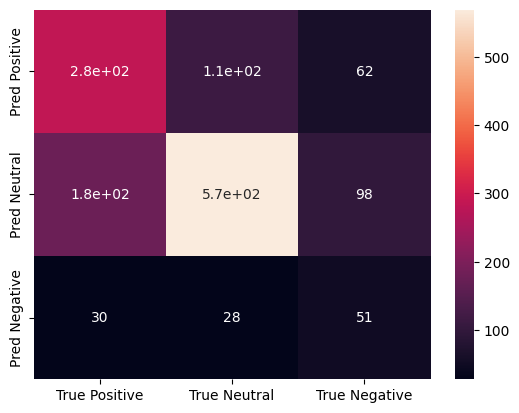

In [100]:
from seaborn import heatmap
pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=0, use_idf=False)),
                 ('clf', SVC(C=1000, gamma=1))])

x_train = text['train']+text['test']
x_test = text['dev']
y_train = labels['train']+labels['test']
y_test = labels['dev']

pipe.fit(x_train, y_train)

prediction = pipe.predict(x_test)

cnf_mtrx = confusion_matrix(prediction, y_test, labels = ['Positive', 'Neutral', 'Negative'])

matrix = pandas.DataFrame(cnf_mtrx, index = ['Pred Positive', 'Pred Neutral', 'Pred Negative'], columns = ['True Positive', 'True Neutral', 'True Negative'])

print(pipe.score(x_test, y_test))
print(heatmap(matrix, annot=True))

the number in each cell is the number of predictions based on what the true value is. xe+y is the same as x*10^y

Researchers have found that humans agree on the sentiment of a sentence about 80-85% of the time (https://mashable.com/archive/sentiment-analysis), meaning that if for example our model gets an accuracy of 100% then from a humans perspective it would still only be about 80% accurate, this also means that the data is inconsistently labelled since about 20% of the labels are disputable, so we should accept accuracies of around 80% as being "ass good as it gets". 
source:
Sentiment Analysis: High-impact Strategies - What You Need to Know: Definitions, Adoptions, Impact, Benefits, Maturity, Vendors

the resulting accuracy is at 64% which seems low, and could probably be higher with more training data, but as we see in the confusion matrix our main problem is the amount of negative labels, there are so few sentences with a negative label that the model struggles at predicting them accurately.

In [63]:
print(f'Number of positive sentiments:{len([x for x in labels_comb if x=="Positive"])}')
print(f'Number of neutral sentiments:{len([x for x in labels_comb if x=="Neutral"])}')
print(f'Number of negative sentiments:{len([x for x in labels_comb if x=="Negative"])}')

Number of positive sentiments:3515
Number of neutral sentiments:5387
Number of negative sentiments:1663


since the model is biased towards neutral data we try to do gridsearch with balanced data and train a new modell

grid search with balanced data

In [88]:
bal_text_comb = []
bal_label_comb = []
n_positive = 0
n_neutral = 0
n_negative = 0

# ballance by looking for lables, 
# adding corresponding text and labels to a list 
# and count different types of labels

for index in range(0, len(labels_comb)):
    label = labels_comb[index]
    match label:
        case 'Positive':
            if n_positive < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_positive += 1
        
        case 'Neutral':
            if n_neutral < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_neutral += 1
        
        case 'Negative':
            if n_negative < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_negative += 1

['Philips 190G6', 'Med integrerte høyttalere som på ingen måte er diskret plassert , og med en stor subwoofer inkludert , da snakker vi om en gutteskjerm .', 'Eller bedrar skinnet ?', 'De fleste skjermer har et diskret design , med smale rammer og slank fot .', 'Men 190G6 fra Philips er en helt annen historie .', 'Den har et utseende som krever oppmerksomhet , med glinsende svart ramme , glansbelegg på skjermflaten og store sølvfargede sidepaneler med fire innfelte høyttalere med svart deksel .', 'LES OGSÅ :', 'Foten har en stor og blank søyle , og det er store knapper og blå lys .', 'Baksiden er sort , blank og skinnende , med et deksel som skjuler kontakter og kabler .', 'De fire høyttalerbrønnene stikker tydelig ut - her er det ikke snakk om å gjemme noe .', 'Likegyldig er det uansett vanskelig å være .', 'God betjening', 'I midten finner vi volumknappen , som roterer fritt .', 'Nivået leser du av på skjermen , det dukker opp en skala så snart du skrur på knappen .', 'Til venstre fi

In [89]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('clf', SVC())])

params = {'clf__C': [0.001, 1, 1000],
          'clf__gamma': [0.1, 1, 10],
          'vect__ngram_range': [(1,1), (1,2), (1,3)],
          'vect__use_idf': [True, False],
          'vect__min_df': [0, 1, 2, 3]}

result = {}
i = 0
times = []

# we itterate trough language models and lists of stopwords so that we can make a dictionary of results.
# and we print the progress of oure search
for model in nb_nlp:
    for stop_list in no_stop:
        # records the current time since inception in seconds
        start = time()

        bal_text_comb = lemmatizer(bal_text_comb, nb_nlp[model], no_stop[stop_list])
        grid = GridSearchCV(pipe, params, n_jobs=-1)
        grid.fit(bal_text_comb, bal_label_comb)

        score = grid.best_score_

        result[score] = grid.best_params_
        result[score]['lemm__models'] = model
        result[score]['lemm__stop'] = stop_list

        stop = time()

        # adds the running time to times list
        times.append(stop-start)

        i += 1

        #find the average time
        time_left_s = ((len(nb_nlp)*len(no_stop))-i)*(sum(times)/len(times))
        
        # translate time to hours minuts and seconds
        if time_left_s < 60.0:
            time_left = f'{time_left_s} seconds'
        else:
            if time_left_s < 3600.0:
                time_left_m = time_left_s/60
                time_left_s = time_left_s%60
                time_left = f'{time_left_m} minuts and {time_left_s} seconds'
            else:
                time_left_h = time_left_s/3600
                time_left_m = (time_left_s%3600)/60
                time_left_s = (time_left_s%3600)%60
                time_left = f'{time_left_h} houres, {time_left_m} minuts and {time_left_s} seconds'

        clear_output(wait=True)
        print('progress')
        print(f'{(i/(len(nb_nlp)*len(no_stop)))*100}% \nestimated time left is: {time_left}')

progress
100.0% 
estimated time left is: 0.0 seconds


In [91]:
max_score = max(result.keys())
print(f'score:{max_score} \nparameters:{result[max_score]}')

score:0.543796318816168 
parameters:{'clf__C': 1, 'clf__gamma': 1, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__use_idf': False, 'lemm__models': 'none', 'lemm__stop': 'none'}


training with new parameters optimized for balanced data

0.5251594613749114
AxesSubplot(0.125,0.11;0.62x0.77)


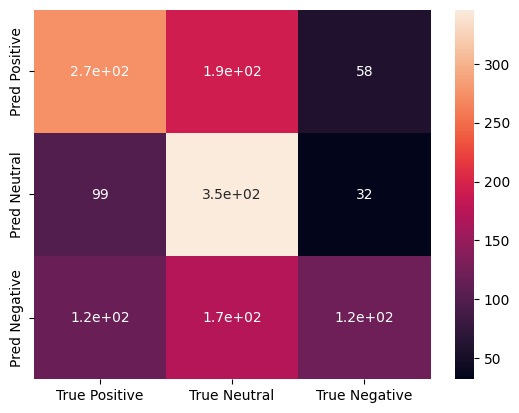

In [101]:
pipe2 = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=2, use_idf=False)),
                 ('clf', SVC(C=1, gamma=1))])

bal_x_train = []
bal_y_train = []
x_train = text['train']+text['test']
y_train = labels['train']+labels['test']

n_positive = 0
n_neutral = 0
n_negative = 0

for index in range(0, len(labels_comb)):
    label = labels_comb[index]
    match label:
        case 'Positive':
            if n_positive < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_positive += 1
        
        case 'Neutral':
            if n_neutral < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_neutral += 1
        
        case 'Negative':
            if n_negative < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_negative += 1


x_test = text['dev']
y_test = labels['dev']

pipe2.fit(bal_x_train, bal_y_train)

prediction = pipe2.predict(x_test)

cnf_mtrx = confusion_matrix(prediction, y_test, labels = ['Positive', 'Neutral', 'Negative'])

matrix = pandas.DataFrame(cnf_mtrx, index = ['Pred Positive', 'Pred Neutral', 'Pred Negative'], columns = ['True Positive', 'True Neutral', 'True Negative'])

print(pipe2.score(x_test, y_test))
print(heatmap(matrix, annot=))

while we get better at predicting negative labels it comes at the cost of lowering oure overall accuracy from 64% to 53%

this function inherits pipe from the previus cell

In [47]:
def pred_n_return():
    """prompts for some sentenc and uses oure model to predict the sentiment of the sentence
    """
    sent = input("Type a sentence in norwegian:")
    result = pipe.predict([sent])
    print(f"the sentence is {result[0]}")

Underneath we have made a function so that you can test the prediction power of our model on Norwegian sentences

In [54]:
pred_n_return()

the sentence is Positive


stopwords sourced from:  
https://searchcode.com/file/257516021/data/stopwords/stopwords-nb.txt/  
https://raw.githubusercontent.com/stopwords-iso/stopwords-no/master/stopwords-no.json

Dataset cloned from github: https://github.com/ltgoslo/norec_sentence

Kutuzov, A., Barnes, J., Velldal, E., Øvrelid, L., & Oepen, S. (2021). Large-Scale Contextualised Language Modelling for Norwegian. Proceedings of the 23rd Nordic Conference on Computational Linguistics (NoDaLiDa 2021).

Øvrelid, L., Mæhlum, P., Barnes, J., & Velldal, E. (2020). A Fine-grained Sentiment Dataset for Norwegian. Proceedings of the 12th Edition of the Language Resources and Evaluation Conference. Marseille, France, 2020.